In [3]:
%pip install torch parameterfree pandas numpy scikit-learn matplotlib cloudpickle xgboost --quiet

Note: you may need to restart the kernel to use updated packages.


### Helpful Sources about Architectures

+ If normalizing do it before activation https://forums.fast.ai/t/why-perform-batch-norm-before-relu-and-not-after/81293/4
+ What are residual networks https://arxiv.org/pdf/1512.03385.pdf
+ When building residual networks use pre-activation https://arxiv.org/abs/1603.05027
+ There is not one universal best normalization method https://proceedings.neurips.cc/paper/2021/hash/2578eb9cdf020730f77793e8b58e165a-Abstract.html
+ Adam is the standard optimizer but takes a lot of tuning. COCOB tunes automatically https://github.com/bremen79/parameterfree
+ Smaller batches tend to be better? (this seems to be with fixed epochs though so may not be relevant) https://arxiv.org/pdf/1804.07612.pdf

### Basic Architectures

In [12]:
import torch

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, norm='l'):
        super().__init__()

        if norm == 'l': norm = [torch.nn.LayerNorm  (in_features)]
        if norm == 'b': norm = [torch.nn.BatchNorm1d(in_features)]

        input_norm   = norm or []
        output_layer = torch.nn.Linear(in_features=in_features, out_features=out_features)
        self.layers  = torch.nn.Sequential(*input_norm, output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class Mlp(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, norm='l'):
        super().__init__()

        def norm_layer(in_width, out_width, norm):
            norm = torch.nn.LayerNorm(out_width) if norm == 'l' else torch.nn.BatchNorm1d(out_width)
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width), norm, torch.nn.ReLU())

        def no_norm_layer(in_width, out_width):
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width), torch.nn.ReLU())

        def layer(in_width, out_width, norm):
            if norm:
                return norm_layer(in_width, out_width, norm)
            else:
                return no_norm_layer(in_width, out_width)

        width = width or in_features

        input_layer   =   layer(in_features, width       , norm)
        hidden_layers = [ layer(width      , width       , norm) for _ in range(depth) ]
        output_layer  =   torch.nn.Linear(in_features=width, out_features=out_features)

        self.layers  = torch.nn.Sequential(input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class MlpDropout(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, drop=(.2,.5)):
        super().__init__()

        def layer(in_width,out_width,drop):
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width),torch.nn.Dropout(drop),torch.nn.ReLU())

        width = width or in_features
        input_layer   =   layer(in_features, width       , drop[1])
        hidden_layers = [ layer(width      , width       , drop[1]) for _ in range(depth) ]
        output_layer  =   torch.nn.Linear(in_features=width, out_features=out_features)
        self.layers   = torch.nn.Sequential(torch.nn.Dropout(drop[0]),input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNet(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, norm='l'):
        super().__init__()        

        def norm_layer(in_width, out_width, norm):
            norm = torch.nn.LayerNorm(in_width) if norm == 'l' else torch.nn.BatchNorm1d(width)
            return torch.nn.Sequential(norm,torch.nn.ReLU(),torch.nn.Linear(in_features=in_width,out_features=out_width))

        def no_norm_layer(in_width, out_width):
            return torch.nn.Sequential(torch.nn.ReLU(),torch.nn.Linear(in_features=in_width, out_features=out_width))

        def layer(in_width, out_width, norm):
            return norm_layer(in_width, out_width, norm) if norm else no_norm_layer(in_width, out_width)

        class PreActivationResidualBlock(torch.nn.Module):
            def __init__(self, in_width, norm) -> None:
                super().__init__()
                self.layers = torch.nn.Sequential(layer(in_width,in_width,norm),layer(in_width,in_width,norm))
            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_layer   = torch.nn.Linear(in_features=in_features, out_features=width)
        hidden_layers = [PreActivationResidualBlock(width,norm) for _ in range(depth)]
        output_layer  = layer(width,out_features,norm)

        self.layers  = torch.nn.Sequential(input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNetDropout(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, drop=(.2,.5)):
        super().__init__()

        def layer(in_width,out_width,drop):
            return torch.nn.Sequential(torch.nn.ReLU(),torch.nn.Dropout(drop),torch.nn.Linear(in_features=in_width, out_features=out_width))
        
        class PreActivationResidualBlock(torch.nn.Module):
            def __init__(self, in_width, drop) -> None:
                super().__init__()
                self.layers = torch.nn.Sequential(layer(in_width,in_width,drop),layer(in_width,in_width,drop))
            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_layer   = torch.nn.Linear(in_features=in_features, out_features=width)
        hidden_layers = [PreActivationResidualBlock(width,drop[1]) for _ in range(depth)]
        output_layer  = layer(width,out_features,drop[1])

        self.layers  = torch.nn.Sequential(torch.nn.Dropout(drop[0]),input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

### Utility Methods

In [21]:
from contextlib import contextmanager

def balanced_accuracy_scores(y_true,y_scores):
    n0,n1 = len(y_true)-sum(y_true),sum(y_true)
    c0,c1 = 0,n1
    n0,n1 = n0*2,n1*2

    for s,l in sorted(zip(y_scores,y_true)):
        if l == 0: c0 += 1
        if l == 1: c1 -= 1
        yield (s,(c0/n0+c1/n1))

class hashabledict(dict):
    def __hash__(self):
        return hash(frozenset(self.items()))

class Experiment:

    def __init__(self, feats, lbl, selector, pscaler, ssl, batch, epoch, model, model_args, pid, gscaler=None, S=True, T=False, C=False):
        import torch
        self._fts  = feats
        self._lbl  = lbl
        self._sel  = selector
        self._pscl = pscaler
        self._gscl = gscaler
        self._ssl  = ssl
        self._b    = batch
        self._e    = epoch
        self._mod  = model
        self._args = model_args
        self._pid  = pid
        self._mse  = torch.nn.MSELoss()
        self._bce  = torch.nn.BCEWithLogitsLoss()
        self._fts2 = (S,T,C)

        model_name = model.__name__ if model else None

        hdrs = ['feats','select','pscale','ssl','batch','epoch','model','model_args','gscale','S','T','C']
        vals = [feats,str(selector),str(pscaler),ssl,batch,epoch,model_name,model_args,str(gscaler),str(S),str(T),str(C)]
        self._key  = hashabledict(zip(hdrs,vals))
        if pscaler  is None: self._key.pop('pscale')
        if gscaler  is None: self._key.pop('gscale')
        if selector is None: self._key.pop('select')

        self._in  = None
        self._out = None

    def load_data(self):
        import pandas as pd
        import torch

        (S,T,C) = self._fts2
        df = pd.read_csv(f'data/sims_main1.csv')[['participant_id','experience_id','phase_id']].drop_duplicates()
        
        if S: df = pd.merge(df, self._sensor_df ())
        if T: df = pd.merge(df, self._trait_df  ())
        if C: df = pd.merge(df, self._context_df())

        if self._gscl:
            is_feat = df.columns[3:]
            df[is_feat] = df[is_feat].astype(float)
            df[is_feat] = self._gscl.fit_transform(df[is_feat].to_numpy().astype(float))

        ssl = int(self._ssl)

        if ssl: X = df.groupby(['participant_id','phase_id','experience_id']).head(n=-ssl).reset_index(drop=True)
        if ssl: Y = df.groupby(['participant_id','phase_id','experience_id']).tail(n=-ssl).reset_index(drop=True)

        if not ssl: X = df
        if not ssl: Y = df[['participant_id','phase_id','experience_id']]

        if self._lbl == 'is_pre' : L = self._is_pre_df()
        if self._lbl == 'sub_anx': L = self._sub_anx_df()

        Y = pd.merge(Y,L)
        #we merge with X and then drop the label from X to
        #handle when L doesn't have a label for every X
        X = pd.merge(X,L).iloc[:,:-1]

        is_tst = Y['participant_id'] == self._pid
        is_trn = ~is_tst

        if self._sel:
            S = 3+self._sel.fit(X[is_trn].iloc[:,3:], Y[is_trn].iloc[:,-1]).get_support(indices=True)
            if X.shape[1] > 3: X = X.iloc[:,[0,1,2,*S   ]]
            if Y.shape[1] > 4: Y = Y.iloc[:,[0,1,2,*S,-1]]

        G = torch.tensor(X.loc[:,'participant_id'],dtype=torch.int)[:,None]
        X = torch.tensor(X.iloc[:,3:].to_numpy(),dtype=torch.float)
        Y = torch.tensor(Y.iloc[:,3:].to_numpy(),dtype=torch.float)

        self._in  = X.shape[1]
        self._out = Y.shape[1]

        return (X[is_trn], Y[is_trn], G[is_trn], X[is_tst], Y[is_tst], G[is_tst])

    def make_model(self):
        if self._in is None: self.load_data()
        return self._mod(self._in, self._out, *self._args)

    def loss(self, Y_hat, Y_star):
        if self._ssl:
            return (self._mse(Y_hat[:,:-1],Y_star[:,:-1]) + self._bce(Y_hat[:,-1:],Y_star[:,-1:]))/2
        else:
            return self._bce(Y_hat,Y_star)

    def test_model(self, model, X_tst, Y_tst):
        scores = torch.nn.Sigmoid()(model(X_tst)[:,-1:]).squeeze().tolist()
        labels = Y_tst[:,-1:].squeeze().tolist()
        return (self._key,labels,scores)

    def _sub_anx_df(self):
        import pandas as pd

        rpt = pd.read_csv('data/self_reports.csv')
        prt = pd.read_csv('data/participants.csv')

        rpt = rpt[rpt.phase      != 'baseline']
        rpt = rpt[rpt.experience != 'alone_video']
        rpt['participant_number'] = rpt['PID']

        prt.participant_number = prt.participant_number.str[1:].astype(int)
        prt = prt[['participant_id','participant_number']]

        cols = ['experience_id','experience']
        data = [[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']]
        exp  = pd.DataFrame(data=data,columns=cols)

        cols = ['phase_id','phase']
        data = [[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']]
        phs  = pd.DataFrame(data=data,columns=cols)

        L = rpt[['participant_number','experience','phase','calm_anx']]
        L = pd.merge(pd.merge(pd.merge(L,exp),phs),prt)
        L = L[['participant_id','experience_id','phase_id','calm_anx']]

        L['calm_anx'] = L['calm_anx'].astype(float)

        #from sklearn.preprocessing import RobustScaler
        #scaler = RobustScaler()
        #for pid in set(L.participant_id):
        #    is_pid = (L.participant_id==pid)
        #    L.loc[is_pid,['calm_anx']] = scaler.fit_transform(L.loc[is_pid,['calm_anx']])

        L['calm_anx'] = (L['calm_anx'] > 3).astype(float)

        return L

    def _is_pre_df(self):
        import pandas as pd
        df = pd.read_csv('data/sims_labels.csv')
        df['is_pre'] = ((df['experience_id'] != 1) & (df['phase_id'] == 1)).astype(int)
        return df[['participant_id','experience_id','phase_id','is_pre']]

    def _sensor_df(self):
        import pandas as pd
        if self._fts == 'main1' : df = pd.read_csv(f'data/sims_main1.csv')
        if self._fts == 'main2' : df = pd.read_csv(f'data/sims_main2.csv')
        if self._fts == 'series': df = pd.read_csv(f'data/sims_series.csv')

        if self._pscl:
            for pid in set(df.participant_id):
                is_pid, is_feat = (df.participant_id==pid),(df.columns[3:])
                df.loc[is_pid,is_feat] = self._pscl.fit_transform(df.loc[is_pid,is_feat])

        return df

    def _trait_df(self):
        import pandas as pd
        old_names = ['PID','SIAS_sum','BFNE_sum','DERS_SF_mean_all','dass_dep_sum']
        new_names = ['participant_number','SIAS','BFNE','DERS','DASS']
        trt = pd.read_csv('data/trait_data.csv').rename(columns=dict(zip(old_names,new_names)))
        prt = pd.read_csv('data/participants.csv')
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        return pd.merge(trt,prt)[['participant_id','SIAS','BFNE','DERS','DASS']]

    def _context_df(self):
        import pandas as pd
        df = pd.read_csv('data/context.csv')
        df['phase'] = df.phase_id
        return df
    
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps([self._fts,self._lbl,self._sel,self._pscl,self._ssl,self._b,self._e,self._mod,self._args,self._pid,self._gscl,*self._fts2])

    def __setstate__(self,state):
        import cloudpickle
        self.__init__(*cloudpickle.loads(state))

def all_pids():
    import pandas as pd
    return sorted(set(pd.read_csv('data/sims_labels.csv').participant_id))

def roc_plot(row,name=None,ax=None):
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(*row[['labels','scores']],name=name,plot_chance_level=True,ax=ax).ax_.set(xlabel="FPR", ylabel="TPR")

def acc_plot(row,name=None,ax=None):
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import ticker as mtick
    from matplotlib import transforms as mtrans
    from sklearn.metrics import balanced_accuracy_score
    
    lbl,scr = row[['labels','scores']]

    X,Y = zip(*balanced_accuracy_scores(lbl,scr))
    z = max(Y)

    ax = ax or plt.figure(figsize=(4.6,4.6)).gca()
    ax.plot(X,Y,label=f"{name} (BBA = {z*100:.2f}%)")
    ax.set_ylabel("Balanced Accuracy")
    ax.set_xlabel("Label Threshold")
    ax.set_aspect((max(X)-min(X))/(max(Y)-min(Y)))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

    ax.axhline(z,alpha=.5)
    trans = mtrans.blended_transform_factory(ax.transAxes,ax.transData)
    ax.annotate(f'{z*100:.2f}%', xy=(1.01, z), xycoords=trans, clip_on=False, va='center')

    if name: ax.legend()

def runner(experiments,device,maxworkers,numrepeats,show=True):
    from matplotlib import pyplot as plt
    from pandas import DataFrame
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score
    from evaluators import evaluator

    numthreads = 3 if maxworkers == 1 else 1

    pool  = ProcessPoolExecutor(max_workers=maxworkers)
    map_  = pool.map if maxworkers > 1 else map
    items = [(e,numthreads,device) for e in experiments]
    evals = {e._key:([],[]) for e,_,_ in items }

    with pool:
        for k,l,s in map_(evaluator,items*numrepeats):
            evals[k][0].extend(l)
            evals[k][1].extend(s)

    get_auc = lambda l,s:roc_auc_score(l,s)
    get_bba = lambda l,s:max(y for _,y in balanced_accuracy_scores(l,s))

    return_df = DataFrame([{**k,'auc':get_auc(l,s),'bba':get_bba(l,s),'labels':l,'scores':s} for k,(l,s) in evals.items()])
    styled_df = return_df.fillna('-').sort_values(by='auc',ascending=False).style.hide(["labels", "scores"],axis=1)

    if show:
        f,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
        acc_plot(styled_df.data.iloc[0,:],"Best Classifier",ax[0])
        roc_plot(styled_df.data.iloc[0,:],"Best Classifier",ax[1])
        plt.tight_layout()

    return styled_df

@contextmanager
def mute_stderr():
    #this doesn't work in jupyter notebook :(
    import os
    import sys

    old_fd = sys.stderr.fileno()
    dup_fd = os.dup(old_fd) 

    #on windows only, dup_fd will be inheritable, see:
    #https://docs.python.org/3/library/os.html#os.dup

    #dup_fd is a new file descriptor which, 
    #when I write to it, writes to fp.
    #fp is still a writeable/readable "file"

    with open(os.devnull, 'bw') as null: 
        sys.stderr.flush()
        os.dup2(null.fileno(), old_fd)

        #at this point old_fd points to
        #the null "file". If we try to
        #write/read from fp now it will
        #write to null because fp is a
        #wrapper around fd.

        #perhaps the best way to think of fds
        #are as indexes to an array of the
        #actual file objects

        #in theory file-descriptors are
        #unique to processes but the stdin,
        #stdout, and stdin file-descriptors
        #are unique in that they are passed
        #to all child processes by default
        try:
            yield None 
        finally:
            sys.stderr.flush()
            os.dup2(dup_fd, old_fd)

# ---------------------- STOP ----------------------

### Is Anticipatory

CPU times: user 46.2 s, sys: 3.22 s, total: 49.4 s
Wall time: 1h 4min 46s


,feats,select,scale,ssl,batch,epoch,model,model_args,auc
10,main1,-,RobustScaler(with_scaling=False),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.673926
8,main1,SelectKBest(),RobustScaler(with_scaling=False),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.665074
13,main2,SelectKBest(),MinMaxScaler(),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.652414
15,main2,-,MinMaxScaler(),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.648989
2,main1,-,RobustScaler(with_scaling=False),True,256,6,ResNet,"(4, 32, 'b')",0.640293
0,main1,SelectKBest(),RobustScaler(with_scaling=False),True,256,6,ResNet,"(4, 32, 'b')",0.640141
5,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNet,"(4, 32, 'b')",0.635510
11,main1,-,MinMaxScaler(),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.625475
12,main2,SelectKBest(),RobustScaler(with_scaling=False),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.622856
9,main1,SelectKBest(),MinMaxScaler(),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.620003


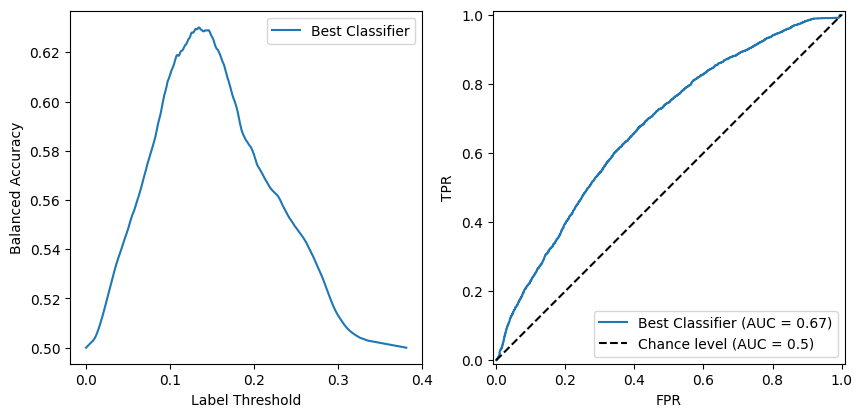

In [17]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from sklearn.feature_selection import SelectKBest

    feats   = ['main1','main2']
    depths  = [4]
    widths  = [32]
    norms   = ['b']
    batches = [256]
    epochs  = [6]
    selects = [SelectKBest(k=10),None]
    scales  = [RobustScaler(with_centering=True, with_scaling=False),MinMaxScaler()]

    for f,a,b,e,sel,scl,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,all_pids()):
        yield Experiment(f, 'is_pre', sel, scl, True, b, e, ResNet, a, pid)

    feats   = ['main1','main2']
    depths  = [8]
    widths  = [256]
    norms   = [(0.2, 0.5)]
    batches = [256]
    epochs  = [30]
    selects = [SelectKBest(k=10),None]
    scales  = [RobustScaler(with_centering=True, with_scaling=False),MinMaxScaler()]

    for f,a,b,e,sel,scl,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,all_pids()):
        yield Experiment(f, 'is_pre', sel, scl, True, b, e, ResNetDropout, a, pid)

(out := runner(experiments(), 'cpu', 35, 10))

### Subjective Anxiety

CPU times: user 11min 8s, sys: 37.2 s, total: 11min 46s
Wall time: 2h 28min 20s


,feats,select,scale,ssl,batch,epoch,model,model_args,auc
413,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNet,"(1, 16, 'b')",0.571158
467,main2,-,MinMaxScaler(),True,256,2,ResNet,"(1, 48, 'b')",0.568259
461,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNet,"(1, 48, 'l')",0.565460
409,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNet,"(1, 16, 'b')",0.565031
425,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNet,"(1, 32, 'l')",0.564977
727,main2,-,MinMaxScaler(),True,256,4,ResNet,"(4, 32, 'b')",0.560786
585,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNet,"(3, 16, 'l')",0.558863
697,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNet,"(4, 16, 'b')",0.554705
607,main2,-,MinMaxScaler(),True,256,8,ResNet,"(3, 16, 'b')",0.554167
503,main2,-,MinMaxScaler(),True,256,4,ResNet,"(2, 16, 'b')",0.553951


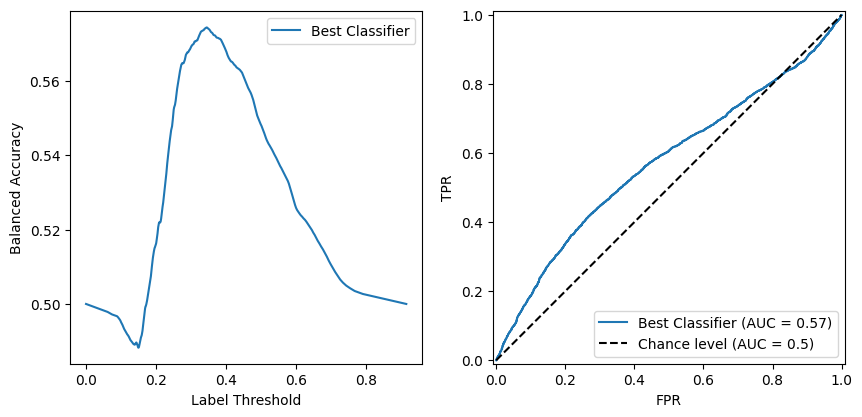

In [19]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from sklearn.feature_selection import SelectKBest

    feats   = ['main1','main2']
    depths  = [1,2,3,4]
    widths  = [16,32,48]
    norms   = ['l','b']
    batches = [256]
    epochs  = [2,4,6,8]
    selects = [SelectKBest(k=10),None]
    scales  = [RobustScaler(with_centering=True,with_scaling=True),MinMaxScaler()]

    for f,a,b,e,sel,scl,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,all_pids()):
        yield Experiment(f, 'sub_anx', sel, scl, True, b, e, ResNet, a, pid)

(out := runner(experiments(), 'cpu', 35, 5))

CPU times: user 4.4 s, sys: 4.13 s, total: 8.52 s
Wall time: 1min 8s


,feats,select,pscale,ssl,batch,epoch,model,model_args,gscale,auc,bba
2,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNet,"(1, 16, 'b')",MinMaxScaler(),0.564160,0.561693
3,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNet,"(1, 16, 'b')",-,0.564155,0.562446
1,main2,SelectKBest(),RobustScaler(),True,256,8,ResNet,"(1, 16, 'b')",-,0.445856,0.501468
0,main2,SelectKBest(),RobustScaler(),True,256,8,ResNet,"(1, 16, 'b')",MinMaxScaler(),0.442945,0.500000


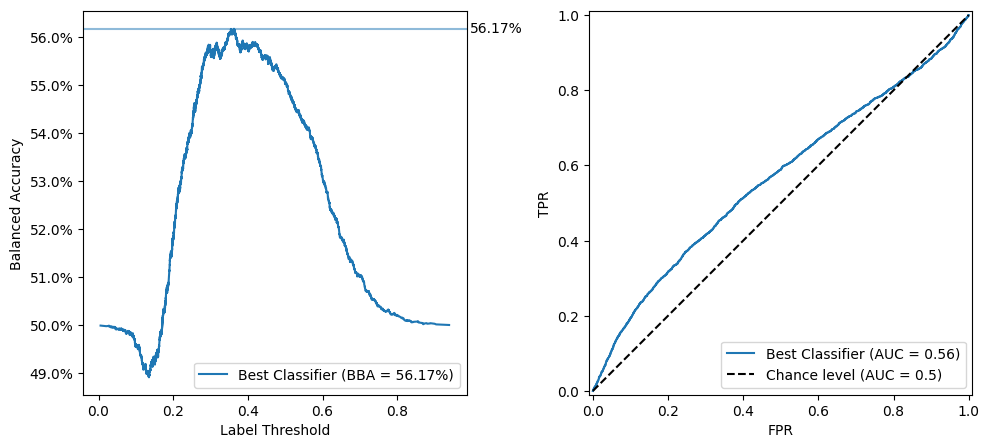

In [28]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from sklearn.feature_selection import SelectKBest

    feats   = ['main2']
    depths  = [1]
    widths  = [16]
    norms   = ['b']
    batches = [256]
    epochs  = [8]
    selects = [SelectKBest(k=10)]
    pscales = [RobustScaler(with_centering=True,with_scaling=True),MinMaxScaler()]
    gscales = [MinMaxScaler(),None]

    for f,a,b,e,sel,pscl,gscl,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,pscales,gscales,all_pids()):
        yield Experiment(f, 'sub_anx', sel, pscl, True, b, e, ResNet, a, pid, gscl)

(out := runner(experiments(), 'cpu', 35, 5))

CPU times: user 5min 34s, sys: 17.9 s, total: 5min 52s
Wall time: 1h 10min 24s


,feats,select,scale,ssl,batch,epoch,model,model_args,auc
237,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(1, 48, (0.2, 0.4))",0.554936
333,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(3, 48, (0.2, 0.4))",0.540921
269,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(2, 32, (0.2, 0.4))",0.533657
377,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNetDropout,"(4, 48, (0.2, 0.4))",0.533214
381,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(4, 48, (0.2, 0.4))",0.530398
329,main2,SelectKBest(),MinMaxScaler(),True,256,6,ResNetDropout,"(3, 48, (0.2, 0.4))",0.526012
221,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(1, 32, (0.2, 0.4))",0.524506
285,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(2, 48, (0.2, 0.4))",0.523541
325,main2,SelectKBest(),MinMaxScaler(),True,256,4,ResNetDropout,"(3, 48, (0.2, 0.4))",0.521062
317,main2,SelectKBest(),MinMaxScaler(),True,256,8,ResNetDropout,"(3, 32, (0.2, 0.4))",0.518551


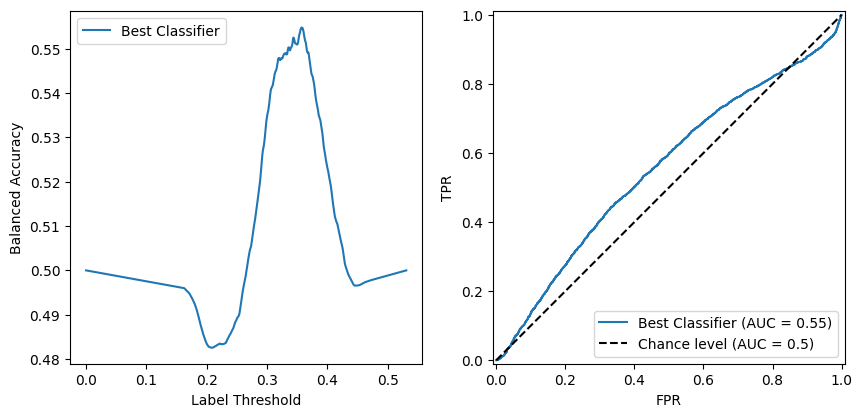

In [4]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from sklearn.feature_selection import SelectKBest

    feats   = ['main1','main2']
    depths  = [1,2,3,4]
    widths  = [16,32,48]
    norms   = [(.2,.4)]
    batches = [256]
    epochs  = [2,4,6,8]
    selects = [SelectKBest(k=10),None]
    scales  = [RobustScaler(with_centering=True,with_scaling=True),MinMaxScaler()]

    for f,a,b,e,sel,scl,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,all_pids()):
        yield Experiment(f, 'sub_anx', sel, scl, True, b, e, ResNetDropout, a, pid)

(out := runner(experiments(), 'cpu', 35, 5))

CPU times: user 1.75 s, sys: 3.73 s, total: 5.48 s
Wall time: 13.8 s


,feats,select,scale,ssl,batch,epoch,model,model_args,auc,bba
0,main2,SelectKBest(),MinMaxScaler(),True,128,2,Mlp,"(1, 16, 'b')",0.578776,0.577450


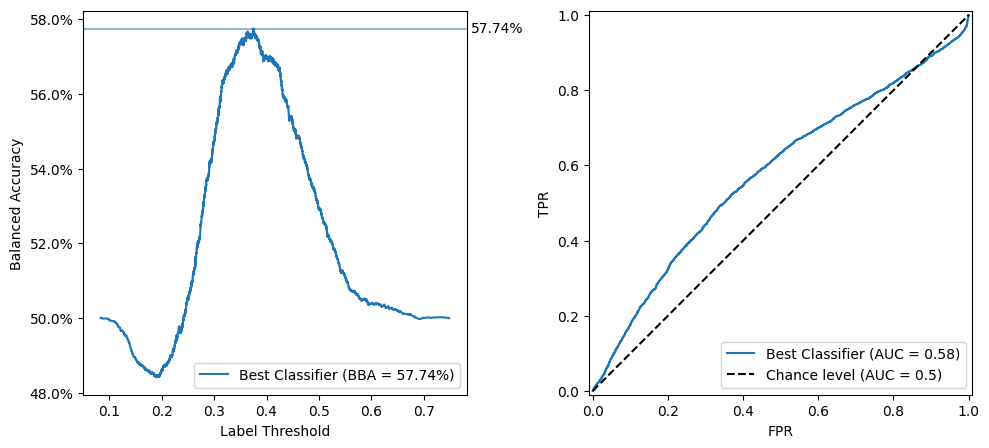

In [256]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from sklearn.feature_selection import SelectKBest

    feats   = ['main2']
    depths  = [1]
    widths  = [16]
    norms   = ['b']
    batches = [128]
    epochs  = [2]
    ssl     = [True]
    selects = [SelectKBest(k=10)]
    scales  = [MinMaxScaler()]

    for f,a,b,e,sel,scl,ss,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,ssl,all_pids()):
        yield Experiment(f, 'sub_anx', sel, scl, ss, b, e, Mlp, a, pid)

(out := runner(experiments(), 'cpu', 35, 5))

CPU times: user 2.48 s, sys: 3 s, total: 5.48 s
Wall time: 42.7 s


,feats,select,pscale,ssl,batch,epoch,model,model_args,gscale,S,T,C,auc,bba
0,main2,SelectKBest(k=15),MinMaxScaler(),True,128,3,Mlp,"(1, 64, 'b')",MinMaxScaler(),True,True,True,0.792682,0.720400
1,main2,SelectKBest(k=15),MinMaxScaler(),True,128,9,ResNet,"(1, 256, 'b')",MinMaxScaler(),True,True,True,0.767972,0.695925


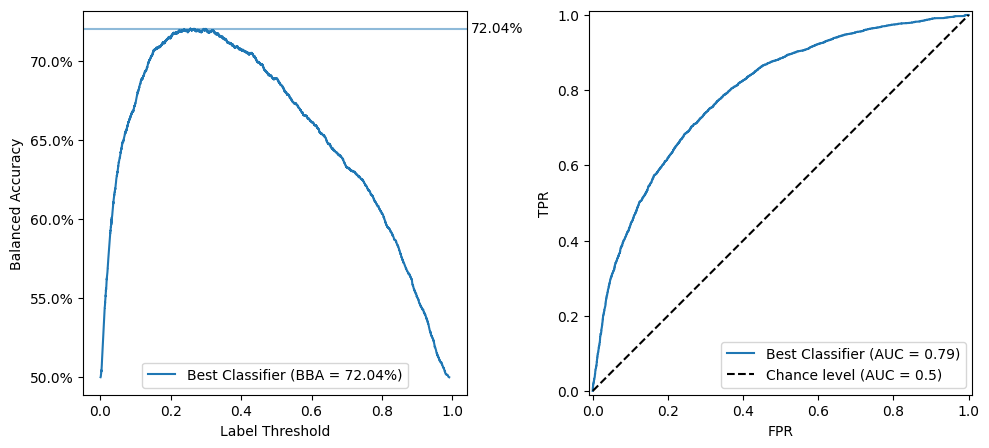

In [20]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from sklearn.feature_selection import SelectKBest, RFECV
    from xgboost import XGBClassifier

    class MyXGBClassifier(XGBClassifier):
        def __init__(self,**kwargs):
            self._kwargs = kwargs
            super().__init__(**kwargs)
        def __str__(self):
            return f'XGBClassifier({self._kwargs})'
        def __repr__(self):
            return f'XGBClassifier({self._kwargs})'

    feats   = ['main2']
    depths  = [1]
    widths  = [64]
    norms   = ['b']
    batches = [128]
    epochs  = [3]
    ssl     = [True]
    selects = [SelectKBest(k=15)]
    scales  = [MinMaxScaler()]

    for f,a,b,e,sel,scl,ss,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,ssl,all_pids()):
        yield Experiment(f, 'sub_anx', sel, scl, ss, b, e, Mlp, a, pid, scl, S=True, T=True, C=True)

    feats   = ['main2']
    depths  = [1]
    widths  = [256]
    norms   = ['b']
    batches = [128]
    epochs  = [9]
    selects = [SelectKBest(k=15)]
    scales  = [MinMaxScaler()]

    for f,a,b,e,sel,scl,pid in product(feats,product(depths,widths,norms),batches,epochs,selects,scales,all_pids()):
        yield Experiment(f, 'sub_anx', sel, scl, True, b, e, ResNet, a, pid, scl, S=True, T=True, C=True)

(out := runner(experiments(), 'cpu', 35, 5))

In [8]:
%%time
def local():
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import RobustScaler, StandardScaler
    from sklearn.feature_selection import SelectKBest, RFECV
    from sklearn.model_selection import cross_validate, LeaveOneGroupOut, StratifiedKFold, GridSearchCV

    sel  = SelectKBest(k=30)#RFECV(XGBClassifier(),step=0.5)
    pscl = RobustScaler()
    gscl = RobustScaler()

    exp = Experiment('main2','sub_anx', sel, pscl, False, 1, 1, None, None, gscl, S=True,T=True,C=True)

    #return exp.load_data()
    #return exp._context_df()
    X,Y,G = exp.load_data()[:3]

    G = G.squeeze().int().numpy()
    Y = Y.squeeze().int().numpy()
    X = X.numpy()
    
    model = XGBClassifier()
    print(("XGB",cross_validate(model, X, Y, scoring='balanced_accuracy', cv=LeaveOneGroupOut(), groups=G, n_jobs=35)['test_score'].mean()))

X = local()

('XGB', 0.6646784986898204)
CPU times: user 1.77 s, sys: 72.3 ms, total: 1.84 s
Wall time: 2.34 s
